In [1]:
import modesto.main
import pandas as pd
import networkx as nx
import modesto.utils as ut
import logging
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')

## Time parameters
Full year optimization

In [3]:
n_steps = 365*24
time_step = 3600
horizon = n_steps*time_step
start_date = pd.Timestamp('20140101')

## Design parameters
Storage size, solar thermal panel size,...

In [4]:
storVol = 75000
solArea = 2*(18300+ 15000)
backupPow = 1.3*3.85e6  # +10% of actual peak boiler power

## Network layout
No network, single node.

In [5]:
netGraph = nx.DiGraph()
netGraph.add_node('Node', x=0, y=0, z=0, comps={
    'backup': 'ProducerVariable',
    'storage': 'StorageVariable',
    'solar': 'SolarThermalCollector',
    'demand': 'BuildingFixed'
})

## Modesto optimizer instance

In [6]:
optmodel = modesto.main.Modesto(horizon=horizon, time_step=time_step, start_time=start_date, graph=netGraph,
                                pipe_model='SimplePipe')

01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter Te
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
01-10 18:55 modesto.Node                         INFO     Initializing Node Node
01-10 18:55 modesto.component.Component          INFO     Initializing Component storage
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter Thi
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter Tlo
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter mflo_max
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter volume
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter ar
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter dIns
01-10 18:55 modesto.parameter.Parameter          INFO     Initializing Parameter kIns
01-10 18:55 modesto.parameter.Parameter          INFO     

## Read demand and production profiles

In [7]:
dem = ut.read_period_data(path='../Data/HeatDemand/Initialized', 
                          name='HeatDemandFiltered.txt', 
                          horizon=horizon, 
                          time_step=time_step, 
                          start_time=start_date
                         )

In [8]:
dem.mean()/1e6*8760

TermienWest          22532.144374
TermienEast          34525.042458
Boxbergheide         82906.063384
Winterslag          118897.669527
OudWinterslag        11934.864401
ZwartbergSouth       34353.996839
ZwartbergNWest       20688.099667
ZwartbergNEast       32898.272320
WaterscheiGarden    140125.924268
Total               498862.077237
dtype: float64

In [9]:
dem = dem['TermienWest'].to_frame()

## Add parameters to ``modesto``

In [10]:
t_amb = ut.read_period_data('../Data/Weather', name='extT.txt', time_step=time_step, horizon=n_steps * time_step,
                                start_time=start_date)
t_g = pd.DataFrame([12 + 273.15] * n_steps, index=range(n_steps))

In [11]:
general_params = {'Te': t_amb,
                  'Tg': t_g}

optmodel.change_params(general_params)

In [12]:
optmodel.change_params({'delta_T': 40,
                        'mult': 1,
                        'heat_profile': dem
                       }, node='Node', comp='demand')

In [13]:
optmodel.change_params({# Thi and Tlo need to be compatible with delta_T of previous
                        'Thi': 80 + 273.15,
                        'Tlo': 40 + 273.15,
                        'mflo_max': 11000000,
                        'volume': storVol,
                        'ar': 0.18,
                        'dIns': 0.15,
                        'kIns': 0.024,
                        'heat_stor': 0
                       }, node='Node', comp='storage')
optmodel.change_init_type('heat_stor', 'cyclic', node='Node', comp='storage')

In [14]:
c_f = ut.read_period_data(path='../Data/Weather',
                          name='extT.txt',
                          time_step=time_step,
                          horizon=n_steps * time_step,
                          start_time=start_date)
prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               # http://ec.europa.eu/eurostat/statistics-explained/index.php/Energy_price_statistics (euro/kWh CH4)
               'Qmax': backupPow,
               'ramp_cost': 0.00,
               'ramp': 10e8 / 3600}

optmodel.change_params(prod_design, node='Node', comp='backup')

In [15]:
optmodel.change_params({'area': solArea, 'delta_T':40}, node='Node', comp='solar')

In [16]:
optmodel.check_data()

True

In [17]:
optmodel.compile()

01-10 18:55 modesto.Node                         INFO     Optimization block initialized for Node
01-10 18:55 modesto.components.VarProducer       INFO     Optimization block for Component backup initialized
01-10 18:55 modesto.component.Component          INFO     Optimization block for Component storage initialized
01-10 18:56 modesto.component.Component          DEBUG    Max heat: 1.254e+13J
01-10 18:56 modesto.component.Component          DEBUG    Tau:      401.633958254d
01-10 18:56 modesto.component.Component          DEBUG    Loss  :   0.999993178573%
01-10 18:56 modesto.component.Component          INFO     Optimization model Storage storage compiled
01-10 18:56 modesto.components.SolThermCol       INFO     Optimization block for Component solar initialized
01-10 18:56 modesto.component.Component          INFO     Optimization block for Component demand initialized
01-10 18:56 modesto.component.Component          INFO     Optimization model <class 'modesto.component.BuildingFix

In [18]:
optmodel.set_objective('energy')

01-10 18:56 modesto.main.Modesto                 DEBUG    energy objective set


In [19]:
optmodel.solve(tee=True, mipgap=0.1)

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 105119 rows, 96362 columns and 227758 nonzeros
Coefficient statistics:
  Matrix range     [8e-12, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e+06, 1e+13]
  RHS range        [5e-11, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 97960 rows and 79765 columns
Presolve time: 0.10s
Presolved: 7159 rows, 16597 columns, 23756 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.159e+03
 Factor NZ  : 1.216e+05 (roughly 10 MBytes of memory)
 Factor Ops : 2.567e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Ti

0

<IPython.core.display.Javascript object>


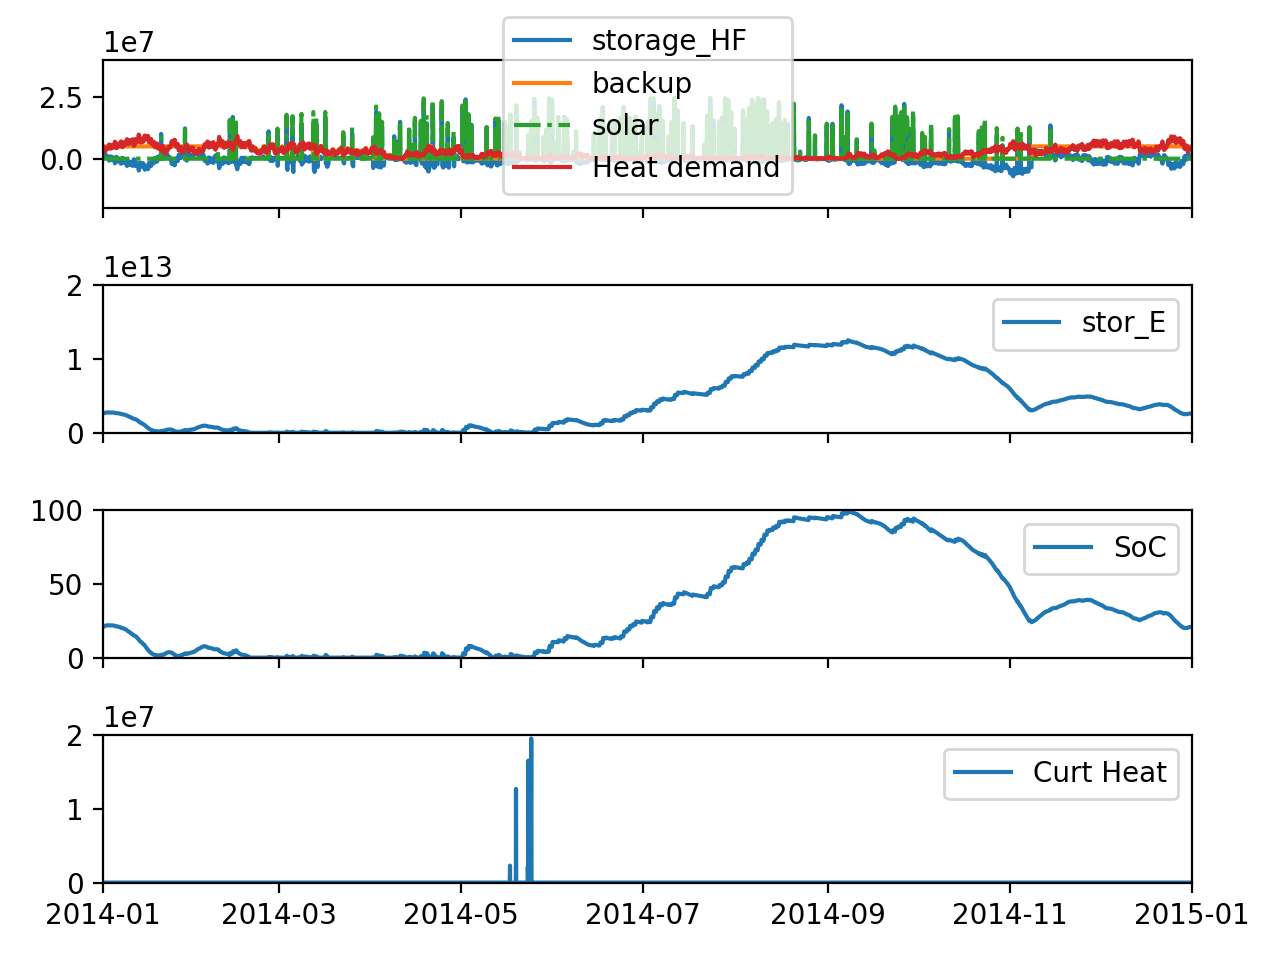

In [20]:
fig, axs = plt.subplots(4,1, sharex=True)

axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='storage'), label='storage_HF')
axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='backup'), label='backup')
axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='solar'),linestyle='-.', label='solar')
axs[0].plot(optmodel.get_result('heat_flow', node='Node', comp='demand'), label='Heat demand')
axs[0].legend()

axs[1].plot(optmodel.get_result('heat_stor', node='Node', comp='storage'), label='stor_E')
axs[1].legend()

axs[2].plot(optmodel.get_result('soc', node='Node', comp='storage'), label='SoC')
axs[2].legend()

axs[3].plot(optmodel.get_result('heat_flow_curt', node='Node', comp='solar'), label='Curt Heat')
axs[3].legend()

fig.tight_layout()

<IPython.core.display.Javascript object>


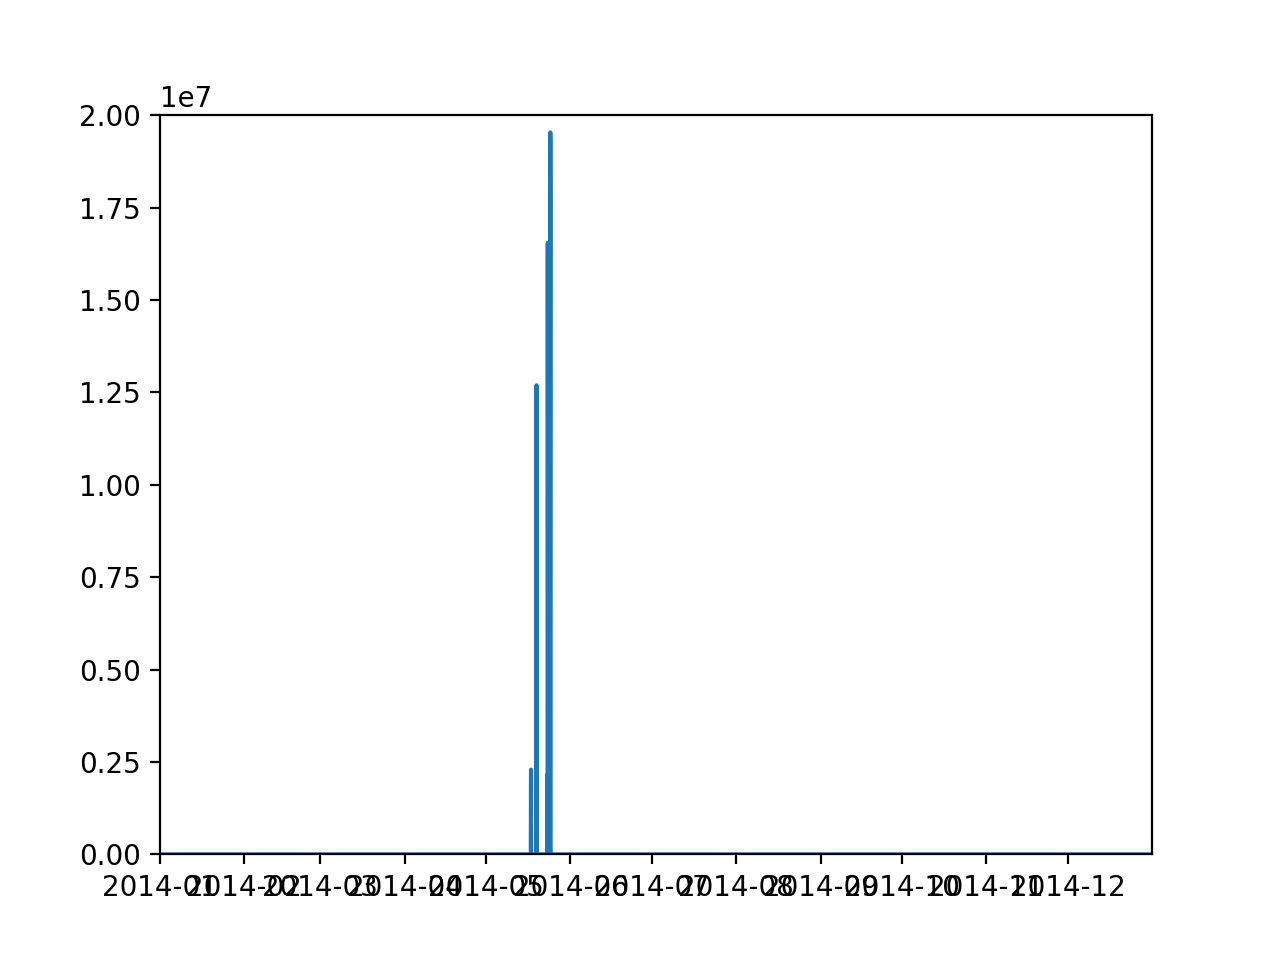

In [21]:
fig, axs = plt.subplots(1,1)

axs.plot(optmodel.get_result('heat_flow_curt', node='Node', comp='solar'), label='Curt Heat')

<IPython.core.display.Javascript object>


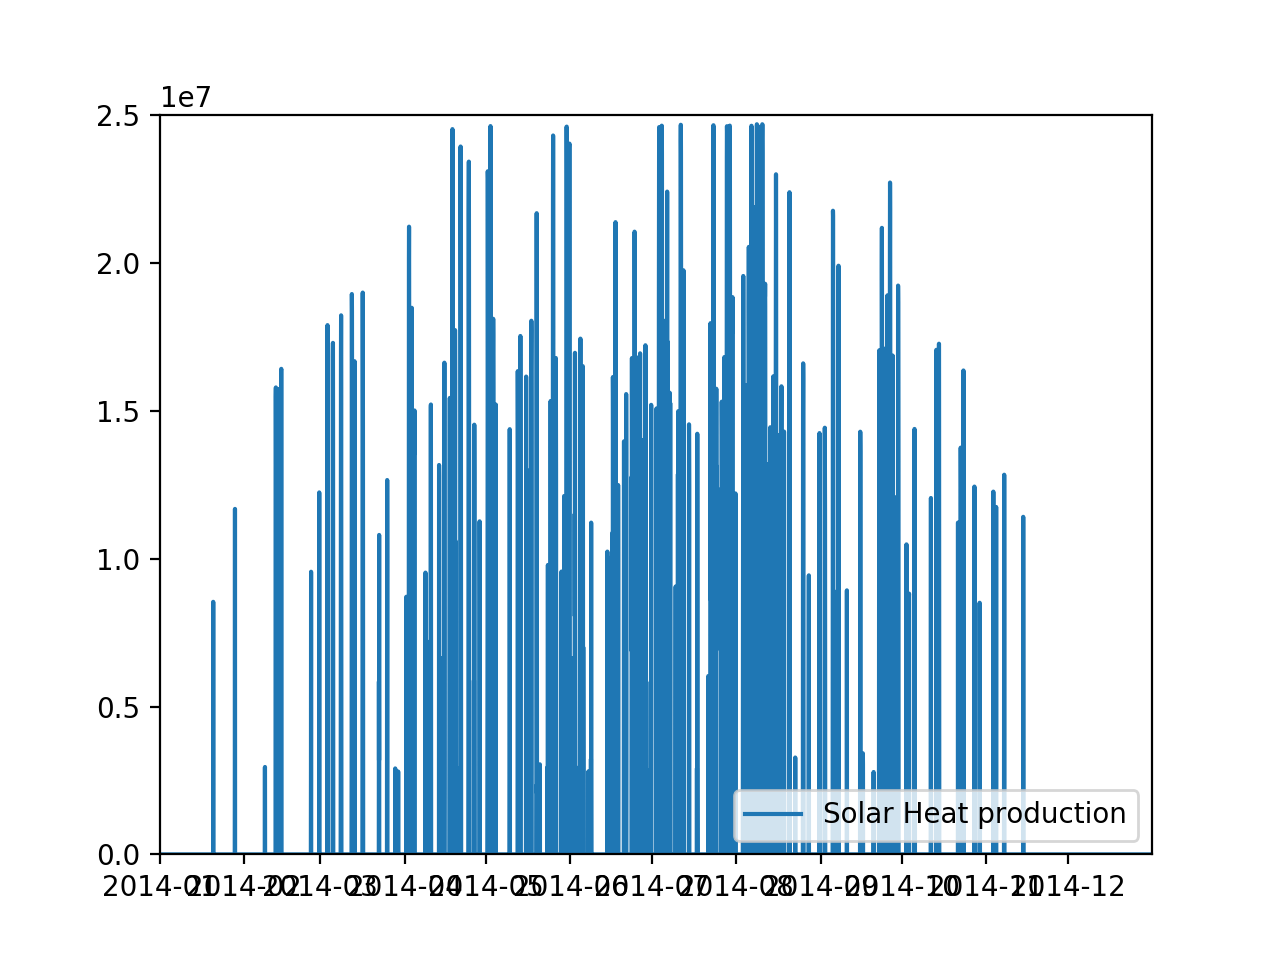

In [22]:
fig, axs = plt.subplots(1,1)

axs.plot(optmodel.get_result('heat_flow', node='Node', comp='solar'), label='Solar Heat production')
axs.legend()

<IPython.core.display.Javascript object>


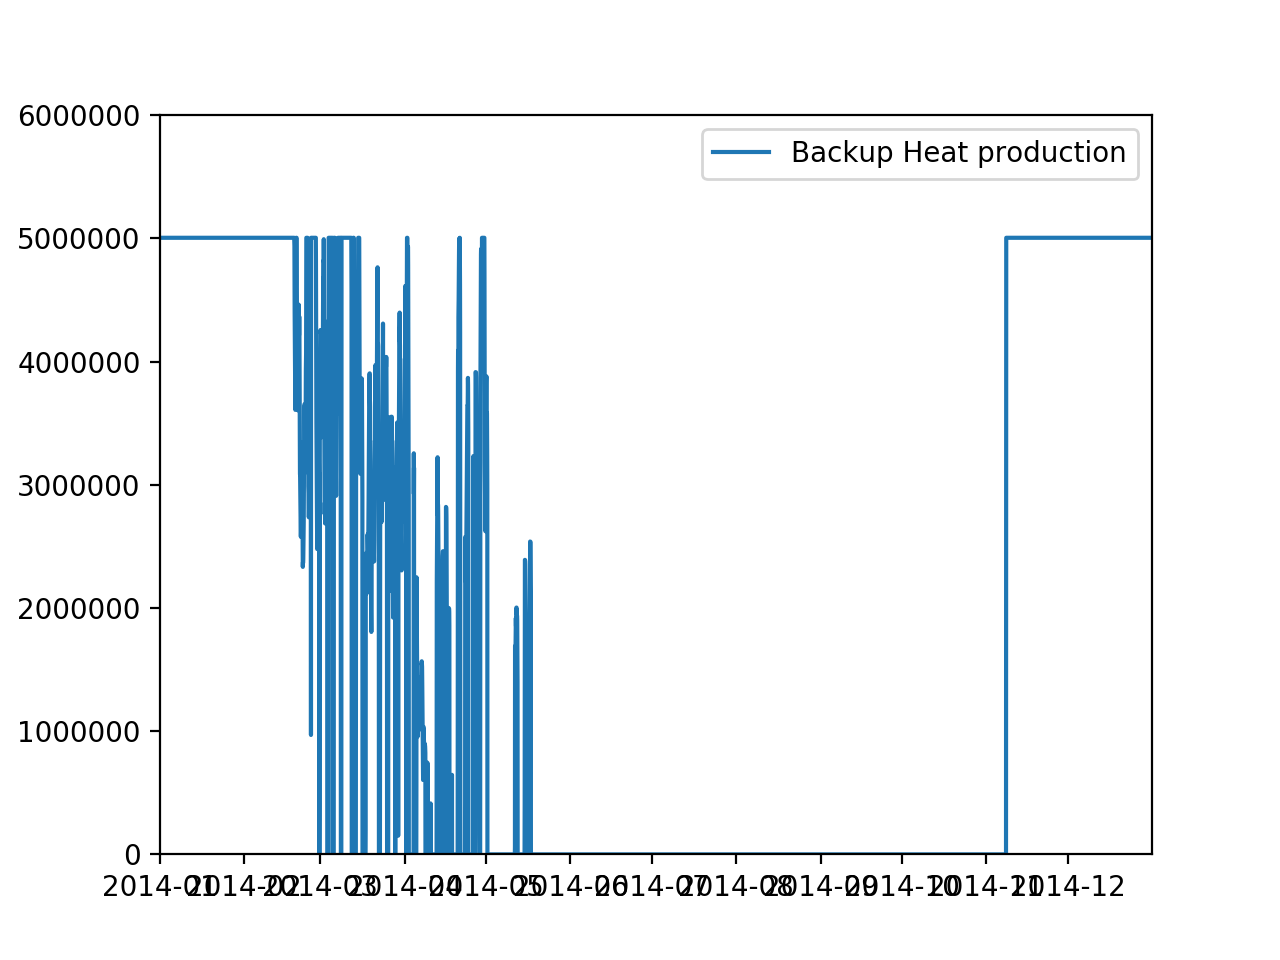

In [23]:
fig, axs = plt.subplots(1,1)

axs.plot(optmodel.get_result('heat_flow', node='Node', comp='backup'), label='Backup Heat production')
axs.legend()

<IPython.core.display.Javascript object>


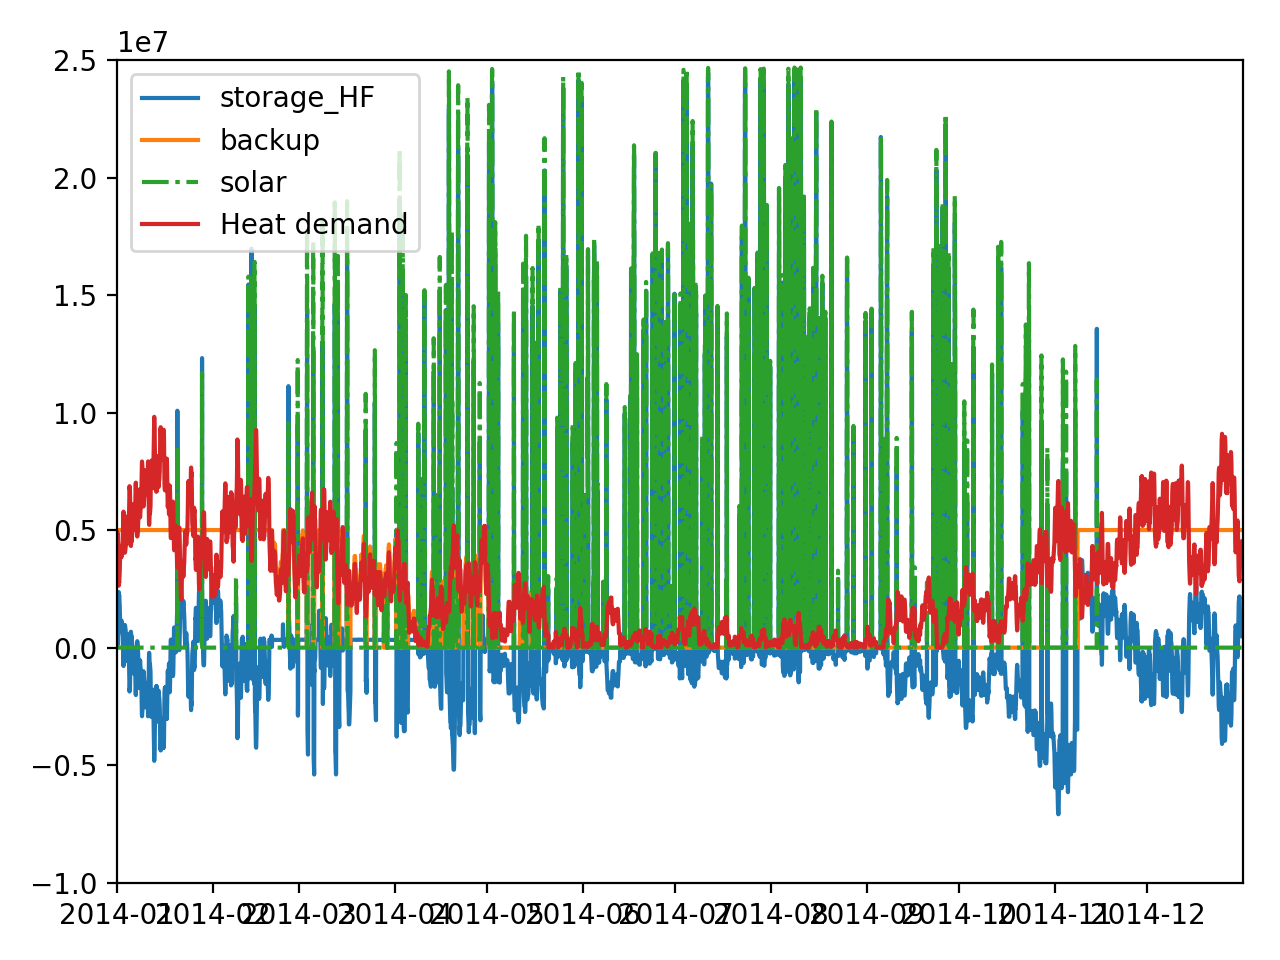

In [24]:
fig, axs = plt.subplots()

axs.plot(optmodel.get_result('heat_flow', node='Node', comp='storage'), label='storage_HF')
axs.plot(optmodel.get_result('heat_flow', node='Node', comp='backup'), label='backup')
axs.plot(optmodel.get_result('heat_flow', node='Node', comp='solar'),linestyle='-.', label='solar')
axs.plot(optmodel.get_result('heat_flow', node='Node', comp='demand'), label='Heat demand')
axs.legend()

fig.tight_layout()